/tmp/ipykernel_43294/2511386990.py:58: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap(cmap_name)(norm(values))


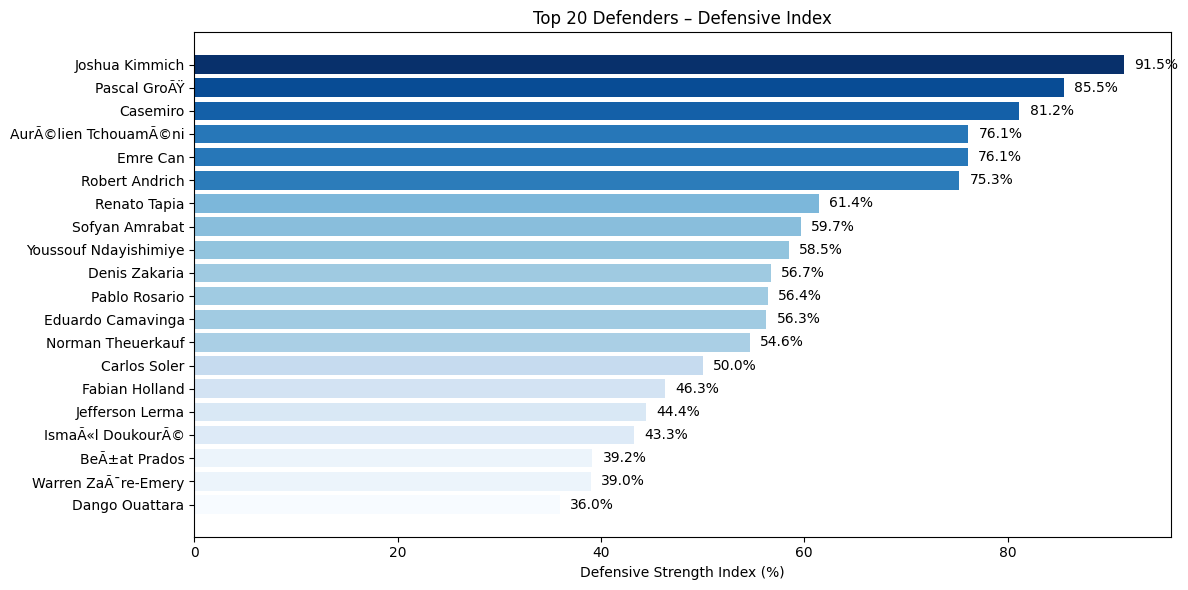

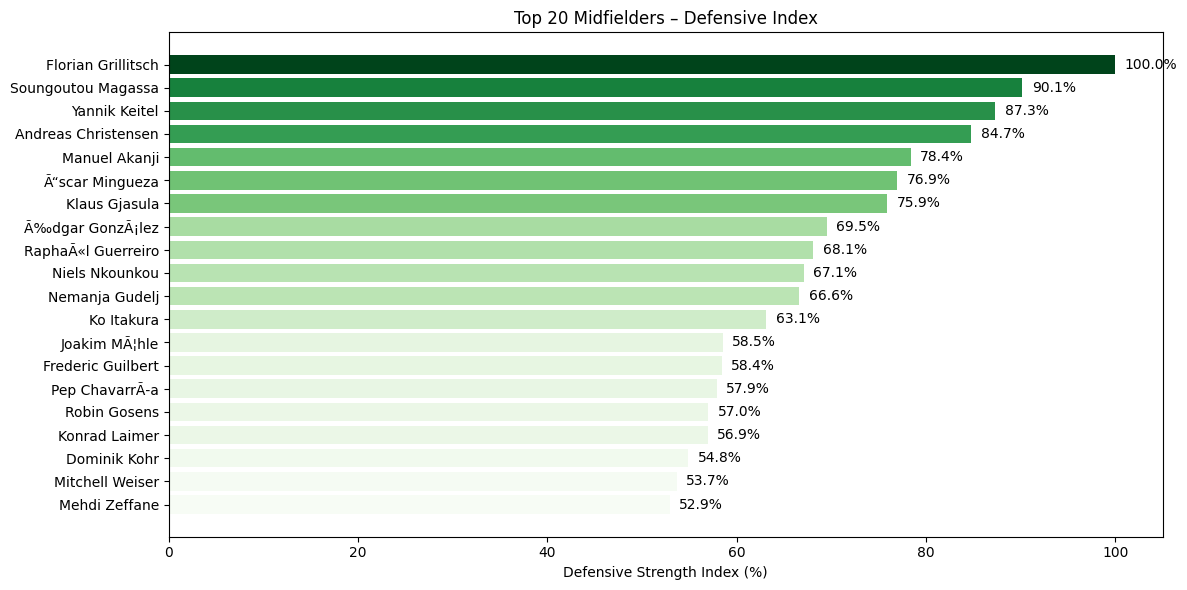

In [1]:
#code de Raphael
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm

# Charger ton dataset propre
df_clean = pd.read_csv("../data/processed/players_clean.csv")

# 1) Saison 2023 uniquement
df_last2 = df_clean[df_clean["season"] == 2023].copy()

# 2) Minimum 900 minutes (~10 matchs)
df_last2 = df_last2[df_last2["minutes"] >= 900].copy()

# 3) Coefficient UEFA par ligue
coeff_dict = {
    "ENG-Premier League": 10.4303,
    "ITA-Serie A": 9.0284,
    "ESP-La Liga": 8.9489,
    "GER-Bundesliga": 8.6624,
    "FRA-Ligue 1": 6.6831,
}

df_last2["uefa_coefficient"] = df_last2["league"].map(coeff_dict).fillna(0)

# 4) Defensive Strength Index (version adaptée à tes colonnes)
#    On n’a pas % duels aériens gagnés, erreurs menant à un tir, etc.
#    On se base sur : tacles gagnés, interceptions, blocs, un peu de progression + coeff UEFA.

df_last2["DSI"] = (
    df_last2["tackles_won"] * 2.5
    + df_last2["interceptions"] * 2.5
    + df_last2["blocks"] * 2.0
    + df_last2["prog_passes"] * 0.5
    + df_last2["prog_carries"] * 0.5
    + df_last2["uefa_coefficient"]
)

# 5) Normalisation 0–100
df_last2["Def Index"] = (
    (df_last2["DSI"] - df_last2["DSI"].min())
    / (df_last2["DSI"].max() - df_last2["DSI"].min())
) * 100

# 6) Tri décroissant
df_sorted = df_last2.sort_values("Def Index", ascending=False)

# 7) Top 20 défenseurs et milieux
df_def = df_sorted[df_sorted["pos"] == "DF"].head(20)
df_mid = df_sorted[df_sorted["pos"] == "MF"].head(20)

# 8) Fonction de plot
def plot_top20(df_subset, title, cmap_name="Greens"):
    players = df_subset["player"]
    values = df_subset["Def Index"]

    norm = plt.Normalize(values.min(), values.max())
    colors = cm.get_cmap(cmap_name)(norm(values))

    plt.figure(figsize=(12, 6))
    bars = plt.barh(players, values, color=colors)
    plt.gca().invert_yaxis()

    for bar, val in zip(bars, values):
        plt.text(
            bar.get_width() + 1,
            bar.get_y() + bar.get_height() / 2,
            f"{val:.1f}%",
            va="center",
            ha="left",
            fontsize=10
        )

    plt.title(title)
    plt.xlabel("Defensive Strength Index (%)")
    plt.tight_layout()
    plt.show()

# 9) Graphiques
plot_top20(df_def, "Top 20 Defenders – Defensive Index", cmap_name="Blues")
plot_top20(df_mid, "Top 20 Midfielders – Defensive Index", cmap_name="Greens")


/tmp/ipykernel_43294/4030875112.py:59: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap(cmap_name)(norm(values))


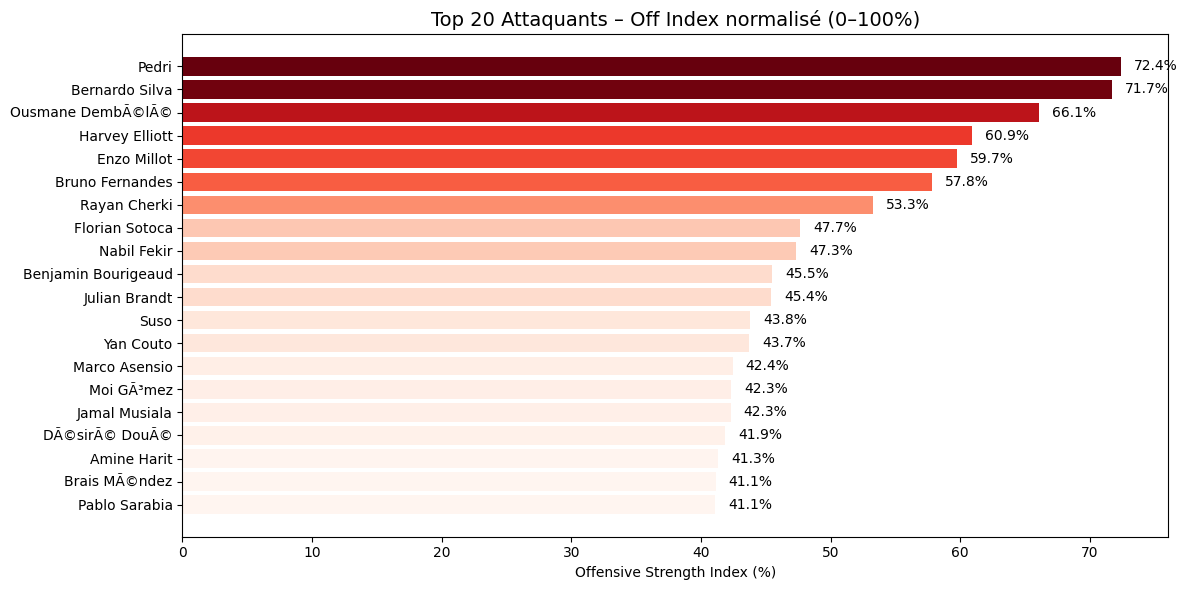

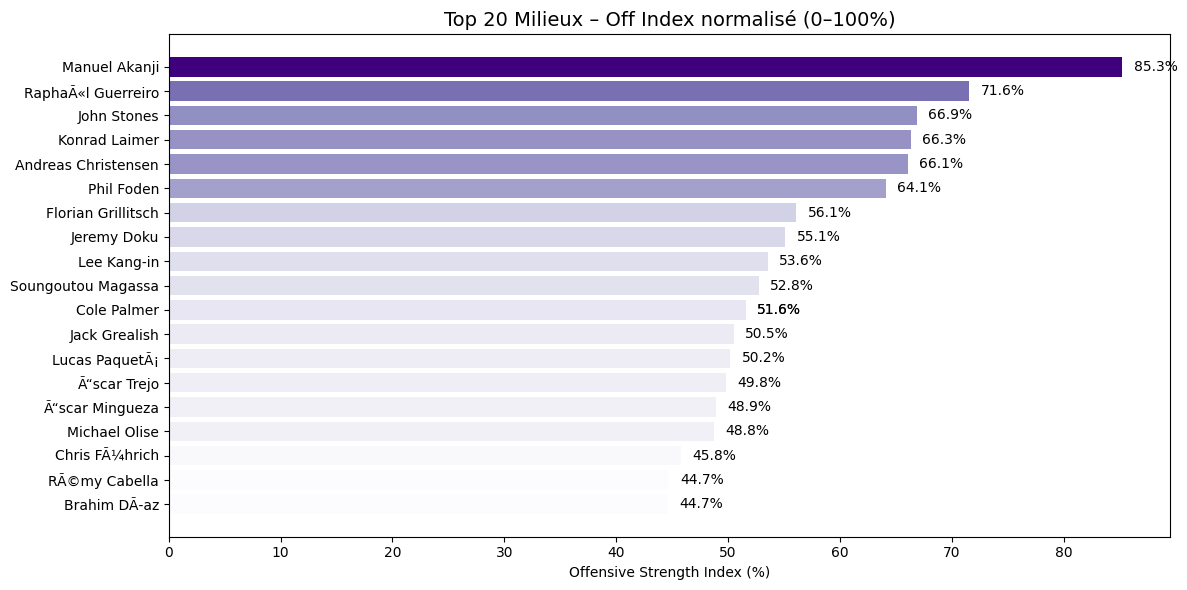

In [2]:
#code de Raphael
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm

# Charger le dataset propre
df_clean = pd.read_csv("../data/processed/players_clean.csv")

# 1) Garder uniquement la saison 2023
df_last = df_clean[df_clean["season"] == 2023].copy()

# 2) Joueurs avec au moins 900 minutes (≈ 10 matchs)
df_last = df_last[df_last["minutes"] >= 900].copy()

# 3) Ajouter le coefficient UEFA par ligue
coeff_dict = {
    "ENG-Premier League": 10.4303,
    "ITA-Serie A": 9.0284,
    "ESP-La Liga": 8.9489,
    "GER-Bundesliga": 8.6624,
    "FRA-Ligue 1": 6.6831,
}

df_last["uefa_coefficient"] = df_last["league"].map(coeff_dict).fillna(0)

# 4) Construire xG / tir (on n’a pas la colonne, on la calcule)
df_last["xg_per_shot"] = df_last["xg"] / df_last["shots_total"]
df_last["xg_per_shot"] = df_last["xg_per_shot"].fillna(0)

# 5) Offensive Strength Index (sans % duels aériens, qu’on n’a pas)
df_last["OSI"] = (
    df_last["g_minus_pk"] * 1
    + (df_last["gls"] - df_last["g_minus_pk"]) * 0.5
    + df_last["shots_total"] * 0.1
    + df_last["shots_on_target"] * 1.8
    + df_last["xg"] * 1.2
    + df_last["xg_per_shot"] * 0.5
    + df_last["uefa_coefficient"]
)

# 6) Normalisation 0–100
df_last["Off Index"] = (
    (df_last["OSI"] - df_last["OSI"].min())
    / (df_last["OSI"].max() - df_last["OSI"].min())
) * 100

# 7) Tri décroissant
df_sorted = df_last.sort_values("Off Index", ascending=False)

# 8) Séparer attaquants et milieux
df_attack = df_sorted[df_sorted["pos"] == "FW"].head(20)
df_mid    = df_sorted[df_sorted["pos"] == "MF"].head(20)

def plot_top20(df_subset, title, cmap_name="Blues"):
    players = df_subset["player"]
    values = df_subset["Off Index"]

    norm = plt.Normalize(values.min(), values.max())
    colors = cm.get_cmap(cmap_name)(norm(values))

    plt.figure(figsize=(12, 6))
    bars = plt.barh(players, values, color=colors)

    # meilleur en haut
    plt.gca().invert_yaxis()

    for bar, val in zip(bars, values):
        plt.text(
            bar.get_width() + 1,
            bar.get_y() + bar.get_height() / 2,
            f"{val:.1f}%",
            va="center",
            ha="left",
            fontsize=10,
        )

    plt.title(title, fontsize=14)
    plt.xlabel("Offensive Strength Index (%)")
    plt.tight_layout()
    plt.show()

# 9) Graphiques
plot_top20(df_attack, "Top 20 Attaquants – Off Index normalisé (0–100%)", cmap_name="Reds")
plot_top20(df_mid,    "Top 20 Milieux – Off Index normalisé (0–100%)",   cmap_name="Purples")
